<a href="https://colab.research.google.com/github/kristokeith/MachLearn_Ganjil_2023/blob/main/Week%2013/OCR_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common Prep

In [ ]:
# Import Library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import zipfile

In [ ]:
# Load MNIST
from tensorflow.keras.datasets import mnist

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# Combine train + test
digits_data = np.vstack([train_data, test_data])
digits_labels = np.hstack([train_labels, test_labels])

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Load Kaggle A-Z
!wget https://iaexpert.academy/arquivos/alfabeto_A-Z.zip

# Extract zip file
zip_object = zipfile.ZipFile(file = 'alfabeto_A-Z.zip', mode = 'r')
zip_object.extractall('./')
zip_object.close()

# Read data as df
dataset_az = pd.read_csv('A_Z Handwritten Data.csv').astype('float32')

# Get pixel data only
alphabet_data = dataset_az.drop('0', axis=1)
# Get labels only
alphabet_labels = dataset_az['0']

# Reshape pixel data to 28*28
alphabet_data = np.reshape(alphabet_data.values, (alphabet_data.shape[0], 28, 28))

--2023-11-20 03:20:56--  https://iaexpert.academy/arquivos/alfabeto_A-Z.zip
Resolving iaexpert.academy (iaexpert.academy)... 162.159.134.42
Connecting to iaexpert.academy (iaexpert.academy)|162.159.134.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193643888 (185M) [application/zip]
Saving to: ‘alfabeto_A-Z.zip’

alfabeto_A-Z.zip    100%[===================>] 184.67M   120MB/s    in 1.5s    

2023-11-20 03:20:58 (120 MB/s) - ‘alfabeto_A-Z.zip’ saved [193643888/193643888]



In [ ]:
# Combine MNIST + Kaggle A-Z

alphabet_labels += 10

# Combine both of them
data = np.vstack([alphabet_data, digits_data])
labels = np.hstack([alphabet_labels, digits_labels])

In [ ]:
# Convert data to float32
data = np.array(data, dtype = 'float32')

In [ ]:
# Since Convolutional need 3d data (including depth)
# and our images only in 2d data (because in grayscale format)
# we need to add "the depth" to the data
data = np.expand_dims(data, axis=-1)

# check shape
data.shape

(442450, 28, 28, 1)

In [ ]:
# Preprocess

# Normalize data
data /= 255.0

# Enconde the labels
# LabelBinarizer similar with OneHotEncoder
le = LabelBinarizer()
labels = le.fit_transform(labels)

# Create weight for label
# Check number of data for each labels first
classes_total = labels.sum(axis = 0)

# Create a weight for each data
classes_weights = {}
for i in range(0, len(classes_total)):
  #print(i)
  classes_weights[i] = classes_total.max() / classes_total[i]

# Check the weight for each data
classes_weights

{0: 8.376792698826597,
 1: 7.340992763742541,
 2: 8.272532188841202,
 3: 8.097605377398123,
 4: 8.473769050410317,
 5: 9.15967052114684,
 6: 8.409685863874346,
 7: 7.928835870012341,
 8: 8.472527472527473,
 9: 8.310577752227651,
 10: 4.169370538611291,
 11: 6.671089063221043,
 12: 2.4702037677816224,
 13: 5.7060390763765545,
 14: 5.0546328671328675,
 15: 49.72055030094583,
 16: 10.035577924331829,
 17: 8.011221945137157,
 18: 51.629464285714285,
 19: 6.808548216178029,
 20: 10.320364090665715,
 21: 4.990937338166753,
 22: 4.6875,
 23: 3.0418200946870066,
 24: 1.0,
 25: 2.989762680316426,
 26: 9.94924294562973,
 27: 4.999567698426422,
 28: 1.1942625828703608,
 29: 2.5705712380529007,
 30: 1.993415609487038,
 31: 13.827116212338593,
 32: 5.362110534124629,
 33: 9.21954719387755,
 34: 5.3250759738465785,
 35: 9.51695194206715}

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 1, stratify = labels)

In [ ]:
# Augmentation Using ImageDataGenerator --> Deprecated asap
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmentation = ImageDataGenerator(rotation_range = 10, zoom_range=0.05, width_shift_range=0.1,
                                  height_shift_range=0.1, horizontal_flip = False)

# Build ResNet50

In [ ]:
# Import necessary library
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
def res_identity(x, filters):
  ''' renet block where dimension doesnot change.
  The skip connection is just simple identity conncection
  we will have 3 blocks and then input will be added
  '''
  x_skip = x # this will be used for addition with the residual block
  f1, f2 = filters

  #first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  '''
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
### Combine the above functions to build 50 layers resnet.
def resnet50():

  input_im = Input(shape=(28,28,1))
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(36, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [ ]:
resnet50_model = resnet50()

In [ ]:
# Check summary
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 34, 34, 1)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_53 (Conv2D)          (None, 14, 14, 64)           3200      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_53 (Ba  (None, 14, 14, 64)           256       ['conv2d_53[0][0]']    

In [ ]:
# compile model
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3),
                       metrics=['accuracy'])

In [ ]:
# Create actual labels
name_labels = '0123456789'
name_labels += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
name_labels = [l for l in name_labels]

# Check actual label
print(name_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Train model

In [ ]:
# Set model name, epoch, and batch size
file_model = 'custom_ocr_resnet50.model'
epochs = 20
batch_size = 128

In [ ]:
# Setup checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(file_model, monitor = 'val_loss', verbose = 1, save_best_only=True)

In [ ]:
# Fit the model
history = resnet50_model.fit(augmentation.flow(X_train, y_train, batch_size=batch_size),
                      validation_data = (X_test, y_test),
                      steps_per_epoch = len(X_train) // batch_size, epochs=epochs,
                      class_weight = classes_weights, verbose=1, callbacks=[checkpointer])

Epoch 1/20
2765/2765 [==============================] - ETA: 0s - loss: 11.0483 - accuracy: 0.7677
Epoch 1: val_loss improved from inf to 4.02739, saving model to custom_ocr_resnet50.model
2765/2765 [==============================] - 197s 60ms/step - loss: 11.0483 - accuracy: 0.7677 - val_loss: 4.0274 - val_accuracy: 0.7989
Epoch 2/20
2765/2765 [==============================] - ETA: 0s - loss: 4.2320 - accuracy: 0.8737
Epoch 2: val_loss improved from 4.02739 to 3.52373, saving model to custom_ocr_resnet50.model
2765/2765 [==============================] - 166s 60ms/step - loss: 4.2320 - accuracy: 0.8737 - val_loss: 3.5237 - val_accuracy: 0.6085
Epoch 3/20
2764/2765 [============================>.] - ETA: 0s - loss: 3.6722 - accuracy: 0.8791
Epoch 3: val_loss did not improve from 3.52373
2765/2765 [==============================] - 144s 52ms/step - loss: 3.6719 - accuracy: 0.8791 - val_loss: 17.4893 - val_accuracy: 0.0676
Epoch 4/20
2764/2765 [============================>.] - ETA: 0s 

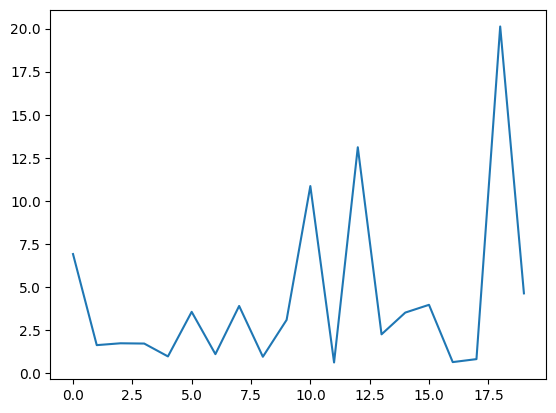

In [ ]:
# Visualize loss value for each epoch
plt.plot(history.history['val_loss'])

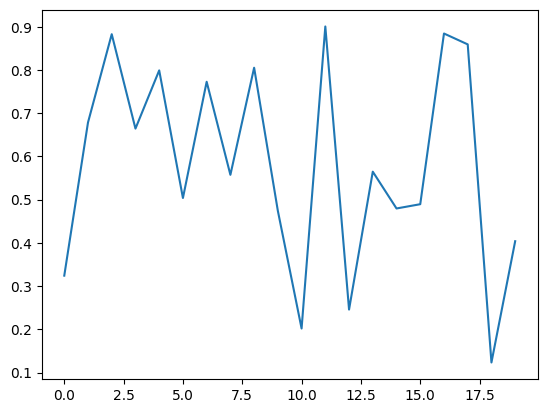

In [ ]:
# Check the model performance by validation accuracy
plt.plot(history.history['val_accuracy'])

In [ ]:
# make a prediction
predictions = resnet50_model.predict(X_test, batch_size=batch_size)

1383/1383 [==============================] - 8s 6ms/step


In [ ]:
# predict
predictions[0]
idx = np.argmax(predictions[0])
name_labels[idx]

'9'

In [ ]:
# Check y_test label for 0
y_test[0]
idx_y = np.argmax(y_test[0])
name_labels[np.argmax(y_test[0])]

'O'

In [ ]:
# Evaluate on test data
resnet50_model.evaluate(X_test, y_test)

2766/2766 [==============================] - 21s 8ms/step - loss: 4.6410 - accuracy: 0.4039


[4.641042232513428, 0.40388745069503784]

In [ ]:
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = name_labels))

              precision    recall  f1-score   support

           0       0.15      0.22      0.18      1381
           1       0.25      0.00      0.00      1575
           2       0.79      0.35      0.49      1398
           3       0.53      0.86      0.66      1428
           4       0.28      0.88      0.42      1365
           5       1.00      0.12      0.22      1263
           6       0.96      0.18      0.30      1375
           7       0.19      0.49      0.27      1459
           8       0.57      0.91      0.70      1365
           9       0.11      0.99      0.20      1392
           A       0.69      0.97      0.81      2774
           B       0.87      0.81      0.84      1734
           C       0.99      0.09      0.16      4682
           D       0.74      0.86      0.80      2027
           E       1.00      0.00      0.01      2288
           F       0.00      0.00      0.00       233
           G       0.06      0.98      0.11      1152
           H       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# The result will show in colab directory
resnet50_model.save('resnet50', save_format= 'h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
